In [2]:
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(Path().resolve().parent/'src'))


from kinematicsrobotics.model import Cluster
from kinematicsrobotics.datahandler import Save, Extract

In [3]:
ext = Extract()
ext._path_project = os.path.abspath(Path().resolve().parent)
#dataset = ext.dataframe(r'src\data\raw\dataset-semi-raw.csv')
dataset = ext.dataframe(r'src\data\ready\dataset-radius-0.5cm.csv')
dataset.shape

(15324, 11)

In [4]:
kmeans = Cluster(data = dataset[['p_x','p_y','p_z']], 
                n_clusters = 4, 
                n_init = 'auto'
)

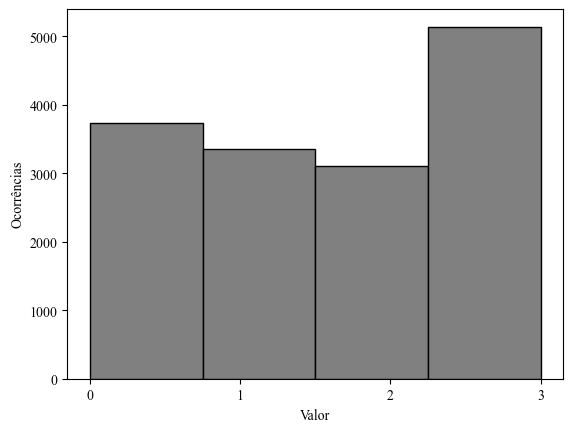

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.rcParams["font.family"] = "Times New Roman"
plt.hist(kmeans._model.labels_, bins=4, color='gray', edgecolor='black')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# Adicionar título e rótulos

plt.xlabel("Valor")
plt.ylabel("Ocorrências")

# Exibir o gráfico
plt.show()


In [12]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# plt.rcParams["font.family"] = "Times New Roman"

# plt.bar(set(kmeans._model.labels_)+1, kmeans._model.labels_, color='gray', edgecolor='black')

# # Adicionar título e rótulos

# #  Adicionar títulos e rótulos
# plt.title('Gráfico de Barras')
# plt.xlabel('Categorias')
# plt.ylabel('Valores')
# # Exibir o gráfico
# plt.show()
(set(kmeans._model.labels_))

{0, 1, 2, 3}

In [79]:
from kinematicsrobotics.model import Model
from kinematicsrobotics.model import Cluster
from kinematicsrobotics.datahandler import Save, Extract
from kinematicsrobotics.dataprocessing import Preprocessing

class LocalModel:
    def __init__(self, *, model_cluster: Cluster, data, **kw):
        self._model_cluster = model_cluster
        self.models(**kw)
        self.clusters(data = data)
    
    
    def models(self, **kw):
        models = []
        for k in self._model_cluster._class_cluster:
            models.append(Model.mlp_regressor(**kw))
        
        self._models = models
    
    def set_model(self,**params):
        for model in self._models:
            model.set_model(**params)

    def fit(self):
        i = 0
        for model in self._models:
            x_train, x_test, y_train, y_test = self._data_processing[i].data_train_test
            model.fit(x = x_train, y = y_train)
            i +=1

    def clusters(self, data):
        clusteres = set(self._model_cluster._model.labels_)
        data_clusters = []
        for cluster in clusteres:
            idex_labes = []
            i = 0
            for labels in self._model_cluster._model.labels_:
                if labels == cluster:
                    idex_labes.append(i)
                i +=1
            data_clusters.append(data.iloc[idex_labes])

        self._data_clusters = data_clusters


    def split(self, *, test_size = 0.1):
        data_processing = []
        for cluster in self._data_clusters:
            data_processing.append(Preprocessing(dataset = cluster, 
                                    x_labels=['p_x', 'p_y','p_z', 'roll', 'pich', 'yaw'],
                                    y_labels=['theta_1', 'theta_2', 'theta_3', 'theta_4'], 
                                    size_test = test_size
                                    )
            )
        self._data_processing = data_processing
            

    # def predict(self,*, x):
    #     return self._model.predict(x)

In [162]:
mlps = LocalModel(model_cluster=kmeans,
                  data = dataset,
                  early_stopping=True, 
                  EPOCHS=1000, 
                  EPOCHS_NOCHANGE=30,
                  random_state=42, 
                  verbose=True,
                  hidden_layer_sizes = (320, 375, 265, 155),
                  activation = 'relu'
                  )

In [163]:
mlps.split(test_size=0.1)

In [164]:
mlps.fit()

Iteration 1, loss = 0.26542087
Validation score: 0.752008
Iteration 2, loss = 0.09139036
Validation score: 0.910725
Iteration 3, loss = 0.05170888
Validation score: 0.938287
Iteration 4, loss = 0.03842586
Validation score: 0.944709
Iteration 5, loss = 0.03128252
Validation score: 0.959359
Iteration 6, loss = 0.02638250
Validation score: 0.965313
Iteration 7, loss = 0.02437103
Validation score: 0.966160
Iteration 8, loss = 0.02194744
Validation score: 0.967730
Iteration 9, loss = 0.02015274
Validation score: 0.970552
Iteration 10, loss = 0.01828884
Validation score: 0.970636
Iteration 11, loss = 0.01711792
Validation score: 0.971762
Iteration 12, loss = 0.01611829
Validation score: 0.975777
Iteration 13, loss = 0.01527279
Validation score: 0.977654
Iteration 14, loss = 0.01459863
Validation score: 0.974914
Iteration 15, loss = 0.01679515
Validation score: 0.965390
Iteration 16, loss = 0.01704523
Validation score: 0.975997
Iteration 17, loss = 0.01386383
Validation score: 0.980005
Iterat

In [165]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

loss = mlps._models[3]._model.loss_curve_

plt.plot(range(1,len(loss)+1), loss, color='black')
plt.xlabel("Épocas")
plt.ylabel("MSE")



[0.286007108031892,
 0.05954290176788805,
 0.025590942766196816,
 0.01577508140277233,
 0.009758402511503677,
 0.008336662219956053,
 0.006688672800187371,
 0.005588225170220068,
 0.007986207769388276,
 0.00830711775584576,
 0.007829018125023833,
 0.007247199318948999,
 0.006293930337606957,
 0.005936106874366884,
 0.004382457639453905,
 0.007669686393263391,
 0.004815333815175849,
 0.00459693157245642,
 0.0041472474255578925,
 0.00285131072393476,
 0.0027012772793908665,
 0.004249298349894794,
 0.004209961058903157,
 0.005913494563230873,
 0.006060069479254591,
 0.0038446095954276093,
 0.0032870362919604295,
 0.0025347303993796754,
 0.0039051807576236906,
 0.0028024629940645754,
 0.0024792305532721245,
 0.002741713752525464,
 0.005087019645981756,
 0.004073894948992518,
 0.0031748437442056876,
 0.004066278030731815,
 0.0032089323382548424,
 0.003939570207751972,
 0.004258170349601642,
 0.002563547670691551,
 0.003807934880784459,
 0.0020891167100172913,
 0.0020796273165652472,
 0.0023

### Métricas

In [166]:
from kinematicsrobotics.kinematics import Robo
from kinematicsrobotics.metrics import Metrics
Elos = [['theta_1',10,0,90,0],
        ['theta_2',0,18,180,0],
        ['theta_3',0,18,-180,0],
        ['theta_4',0,0,90,90],
        ['theta_5',18,0,0,0]
]

robo = Robo("Robo", Elos)


metric = Metrics(model = mlps._models[0],
                 scaler_x = mlps._data_processing[0]._scaler_x , 
                 scaler_y = mlps._data_processing[0]._scaler_y,
                 robo=robo)

In [167]:
x_train, x_test, y_train, y_test = mlps._data_processing[0].data_train_test

In [168]:
metric.mse_joint(x = x_train, y=y_train)

array([0.58137205, 1.13913517, 4.24379963, 1.47145718])

In [169]:
metric.mse_operacional(x=x_train)

array([0.06835117, 0.03737069, 0.03558842])

In [170]:
metric.mse_joint(x = x_test, y=y_test)

array([0.55310491, 0.768259  , 3.17648931, 1.35460025])

In [171]:
metric.mse_operacional(x=x_test)

array([0.06110464, 0.03506326, 0.03578217])

In [172]:
metric = Metrics(model = mlps._models[2],
                 scaler_x = mlps._data_processing[2]._scaler_x , 
                 scaler_y = mlps._data_processing[2]._scaler_y,
                 robo=robo)

x_train, x_test, y_train, y_test = mlps._data_processing[2].data_train_test
metric.mse_joint(x = x_train, y=y_train)

array([0.1881517 , 0.44424366, 1.43616094, 0.61525906])